# Task 1: Resources (10 Points) 
Assuming you are not familiar with the framework, in this part of the 
homework you will present your research describing the resources you used to learn the 
framework (must include links to all resources). Clearly explain why you needed a particular 
resource for implementing a 2-layer Neural Network (NN). (Consider how you will keep track of 
all the computations in a NN i.e., what libraries/tools do you need within this framework.)

## My resources

My Framework:
* I decided to use the pytorch machine learning framework as the core driver of my project. The main reason I selected pytorch for this project its its growing use in academia (https://www.assemblyai.com/blog/pytorch-vs-tensorflow-in-2022/) as well as its more user friendly API and less steep learning curve compared to Tensorflow (I have used both before). Despite already knowing pytorch, I used this as an opportunity to brush up on some of the finer details. The following resources were particularly helpful for general overview:
    * (https://pytorch.org/tutorials/beginner/basics/intro.html)
    * (https://towardsdatascience.com/intro-to-pytorch-part-1-663574fb9675)

For more specific questions about each part, I made heavy use of the documentation and Q&A boards to help guide me in the right direction while implementing my 2 layer NN:

Forward Pass:
* I need linear layers to act as the backbone of the network, giving me the actual "neurons" on each layer (https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear)
* I need to use the RELU function for activation on my hidden layers (https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
* For the output layer I need to use the Softmax activation function since its optimal for classification tasks (https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) Sigmoid isn't as good for classification tasks and should only be used if there are multiple true outputs for the network see (https://stats.stackexchange.com/questions/218542/which-activation-function-for-output-layer). 
* To combine the layers together into a single cohesive model i use the Sequential container (https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)

Cost Function:
* For the cost function I researched for the optimal cost functions for my task of multi-class classification, and found that the ideal cost function is typically Cross Entropy Loss, (implemented in torch as `torch.nn.CrossEntropyLoss`  (https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html), however because I use Softmax as the activation function for the final layer of my network, I instead use mean squared error loss, implemented in torch as `nn.MSELoss` (https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html), which is simpler. More on the specifics of this in task 3 section 4. 

Backpropigation and optimization:
* (https://arxiv.org/abs/2007.14166) provided a good overview of some of the common optimization algorithms that can be used for simple tasks in NNs, it helped me decide on using Adam (https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) as my optimizer due to its slew of good features. 
* the follow was useful for investigating how backprop and the optimization loop can be implemented in torch:
    * (https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html)
    * (https://pytorch.org/docs/stable/notes/autograd.html)
    * (https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html)

Metrics:
* Due to my dataset and our discussions in previous weeks, I settled on using F1 score as my primary metric for evaluating the network due to high class imbalance in the dataset and high cost of false negatives for the task at hand. I use Scikitlearn's implementation as Torch does not provide an implementation (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html?highlight=f1_score#sklearn.metrics.f1_score)



# Task 2: Data & Implementation (60 Points)
Once you have figured the resources you need for the project, design, and 
implement your project. The project must include the following steps (it’s not limited to these 
steps): 
1. Exploratory Data Analysis (Can include data cleaning, visualization etc.) 
2. Perform a train-dev-test split. 
3. Implement forward propagation (clearly describe the activation functions and other 
hyper-parameters you are using). 
4. Compute the final cost function. 
5. Implement gradient descent (any variant of gradient descent depending upon your 
data and project can be used) to train your model. In this step it is up to you as someone 
in charge of their project to improvise using optimization algorithms (Adams, RMSProp 
etc.) and/or regularization.  
6. Present the results using the test set. 

NOTE: In this step, once you have implemented your 2-layer network you may increase and/or 
decrease the number of layers as part of the hyperparameter tuning process.

## Step 1: Problem, Dataset, Exploratory Data Analysis

For this work we select the [shuttle dataset](https://archive.ics.uci.edu/ml/datasets/Statlog+(Shuttle)) and its task of classifying what means of control should be employed while landing the space shuttle based on the 9 features are signals derived from radiator sensors and the time at which they happened. The dataset is already split for us initially so that there is a good distribution of features is maintained across the slit, but we will combine it first and re-split it with a validation set as well for step 2.

In [67]:
import pandas as pd

#create our column names
feature_names = [f"x_{i}" for i in range(9)]
col_names = feature_names + ["y"]

#get our split datasets
old_testing = pd.read_csv("./data/shuttle.trn", names=col_names, sep=" ")
old_training = pd.read_csv("./data/sat.tst", names=col_names, sep=" ")

#combine them into a single dataset for exploratory data analysis.
data = pd.concat([old_testing, old_training])
data["y"] = data["y"] - 1

#print if we have any NaNs or nulls in the dataset
print("NaNs or Nulls present: " + str(data.isnull().values.any()))
data.head()

NaNs or Nulls present: False


,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,y
0,50,21,77,0,28,0,27,48,22,1
1,55,0,92,0,0,26,36,92,56,3
2,53,0,82,0,52,-5,29,30,2,0
3,37,0,76,0,28,18,40,48,8,0
4,37,0,79,0,34,-26,43,46,2,0


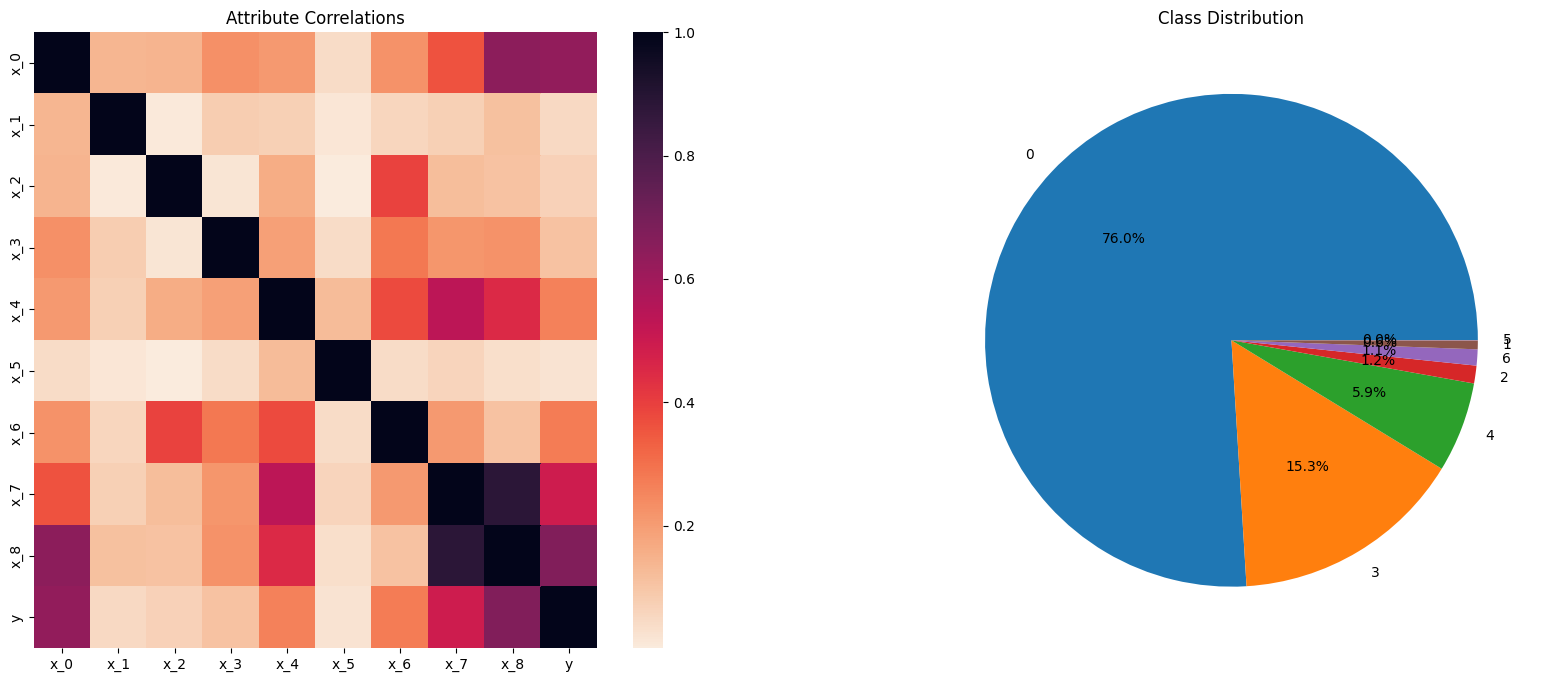

In [68]:
from turtle import title
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(ncols=2, figsize=(20,8))
#ax[0].imshow(data_raw.corr().abs(), cmap='rocket_r')
ax[0].set_title("Attribute Correlations")
sns.heatmap(data.corr().abs(),annot=False, ax=ax[0], cmap='rocket_r')
ax[1].set_title("Class Distribution")
ax[1].pie(x=data["y"].value_counts(), labels=data["y"].value_counts().index, autopct='%1.1f%%');

The corelation heatmap shows some medium corelation between our class and attributes 1 and 8, the rest have relatively low corelation. Our pie chart of class distribution shows a massive class imbalance, with class 1 composing nearly 80% of instances. This high imbalance, combined with stringent consequences for false negatives (millions of dollars of infrastructure are on the line for this decision problem), F1 score is the best metric for measuring performance on this task. 

## Step 2: Data split

When splitting the data, we need to ensure that our very specific class distribution is maintained to the very best of our ability. To ensure this, we use the `stratify` parameter in the `train_test_split` to provide class labels, which causes `train_test_split` to use `StratifiedShuffleSplit` on the backend which shuffles while maintaining even proportions of each class. 

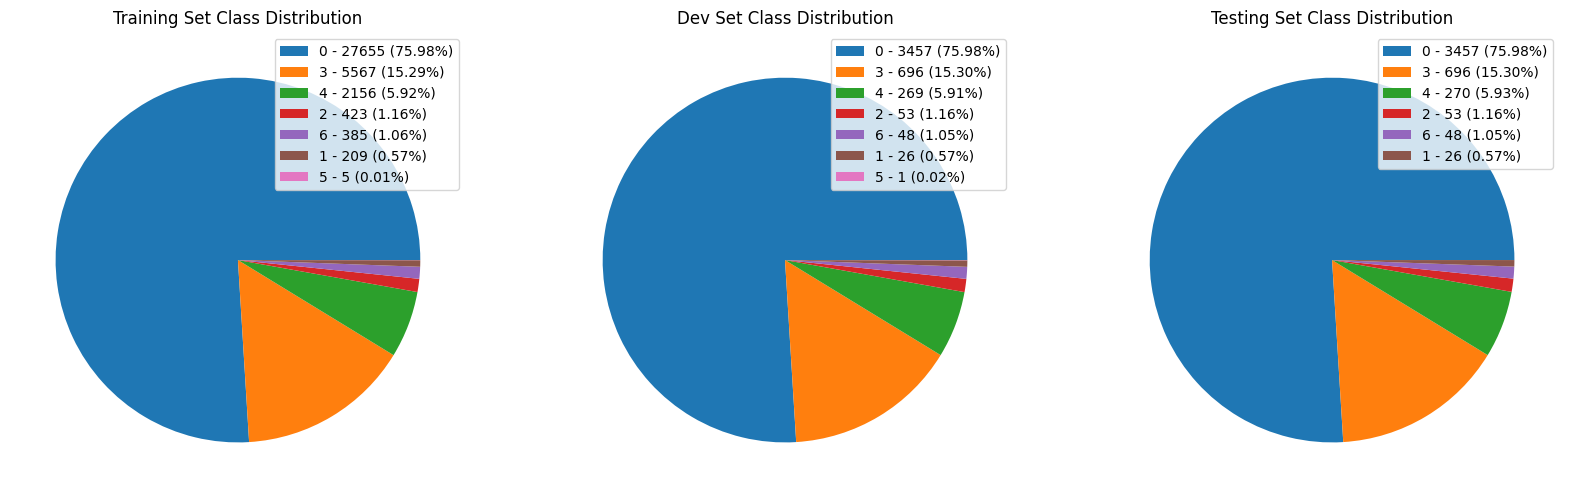

In [69]:
import math
import numpy as np
from sklearn.model_selection import train_test_split

training_percent = 0.8
testing_percent = 0.1
assert(0 < training_percent+testing_percent <= 1)
remainder_size = math.floor((training_percent+testing_percent) * data.shape[0])
testing_size = math.floor(testing_percent * data.shape[0])

x_dev, x_remainder, y_dev, y_remainder = train_test_split(data[feature_names], data["y"], test_size=remainder_size, stratify=data["y"])
x_train, x_test, y_train, y_test = train_test_split(x_remainder, y_remainder, test_size=testing_size, stratify=y_remainder)

#demonstrate our datasets have the same class distributions
fig, ax = plt.subplots(ncols=3, figsize=(20,8))

#plot a pie chart on the given axis breaking down the classes listed in the labels parameter
def pie_chart(axis_index, name, labels):
    unique_labels = np.transpose(np.unique(labels, return_counts=True))
    sorted_labels = np.transpose(unique_labels[unique_labels[:, 1].argsort()[::-1]])
    ax[axis_index].set_title(name + " Set Class Distribution")
    slices, texts = ax[axis_index].pie(sorted_labels[1]);
    pie_labels = [str(i) + " - {} ({:.2f}%)".format(j , 100*float(j/len(labels))) for i, j in  zip(sorted_labels[0], sorted_labels[1])]
    ax[axis_index].legend(slices, pie_labels)

pie_chart(0, "Training", y_train)
pie_chart(1, "Dev", y_dev)
pie_chart(2, "Testing", y_test)

We see that the split is successful in a broad sense, the only problem class being class 6 which doesn't really have enough examples in the dataset to be useful for us anyway.  

## Step 3: Implementing the forward pass

For the forward pass we define a custom model that takes a number of hidden layer widths and joins them with RELU activations. We use RELU since it is the arguably the best choice for hidden layer activation functions (see https://stats.stackexchange.com/questions/218752/relu-vs-sigmoid-vs-softmax-as-hidden-layer-neurons). For our final layer we use Softmax which is a better choice as output activation function than sigmoid for multi-class classification problems, however it does prevent us from using cross entropy loss for our cost function in step 4, due to the way pytorch structures their implementation. We stack our layers into a `torch.nn.Sequential` model and use the built in forward pass it provides to go through our layers, also this will be very useful when implementing gradient decent in step 5. 

In [145]:
import torch
import torch.nn as nn

class MyNeuralNetwork:

    #layer_widths is an array with the widths of each hidden layer in our network
    #layer_widths[0] is the input size and does not correspond to a hidden layer
    #layer_widths[-1] is the output shape and corresponds to the final layer
    def __init__(self, layer_widths):
        self.layer_widths = layer_widths
        assert len(layer_widths) >= 2, "Must have at least input size and output size"
        
        #For each hidden layer we create a linear layer with the given width and use RELU as the activation function
        self.layers = []
        for i in range(1, len(layer_widths)-1):
            self.layers.append(nn.Linear(layer_widths[i - 1], layer_widths[i]))
            self.layers.append(nn.ReLU())

        #For the final layer we use softmax since it is better than sigmoid for classification problems
        self.layers.append(nn.Linear(layer_widths[-2], layer_widths[-1]))
        self.layers.append(nn.Softmax(dim=1))

        #create the model 
        self.model = nn.Sequential(*self.layers)

    # X is the input tensor of features, returns the value
    def forward_pass(self, X):
        return self.model(X)

    #return class predictions from model output
    def predict(self, X):
        return torch.argmax(self.forward_pass(X), dim=1 if len(X.shape) >= 2 else 0)


## Step 4: Computing final cost function

For the cost function, I use mean squared error loss (implemented in torch as `nn.MSELoss`) which is one of the two dominant loss functions for multi-class classification tasks. The other potential option here was Cross Entropy Loss (implemented in torch as `torch.nn.CrossEntropyLoss`), however as previously mentioned, because I use Softmax as the activation function for the final layer of my network, this is not allowed in torches implementation. I could have used negative log likelihood loss (implemented as `torch.nn.NLLLoss`) to get the same result as cross entropy loss, but decided against this and to keep things simple with MSE. 

In [126]:

def MSE_cost(output, ohe_labels):
    #I use MSE Loss rather than cross entropy loss because I'm already using softmax and you're not supposed to use softmax a cross entropy loss in pytorch
    #https://stackoverflow.com/questions/55675345/should-i-use-softmax-as-output-when-using-cross-entropy-loss-in-pytorch
    loss_function = nn.MSELoss() 
    return loss_function(output, ohe_labels)

## Step 5: Implement gradient descent and train the model

For the main training loop we use a main epoch loop with an inner loop that iterates over mini-batches, we allow arbitrary optimizer to be swapped in and will explore the effects of different optimizers during our hyperparameter search. For gradient descent we use torch's method of zeroing the grads in the optimizer, preforming backpropigation on the loss tensor, and updating the gradients in the optimizer step. 

In [146]:

import torch.optim
import torch.utils.data

def fit_model(my_nn: MyNeuralNetwork, optimizer: torch.optim.Optimizer, trainingDataset, batch_size: int, epochs: int, cost):
    my_optimizer = optimizer(my_nn.model.parameters()) #default learning rate
    data_loader = torch.utils.data.DataLoader(trainingDataset, batch_size=batch_size, shuffle=True)
    losses = []
    for epoch in range(epochs):
        print("Epoch: " + str(epoch + 1) + "/" + str(epochs))
        for batch, (X, y) in enumerate(data_loader):

            #forward pass and cost computation
            model_outputs = my_nn.forward_pass(X)
            batch_cost = cost(model_outputs, y)
            losses.append(batch_cost)
            
            #backprop
            my_optimizer.zero_grad()
            batch_cost.backward()
            my_optimizer.step()
        
    return losses
        

### Simple Model Training

In [147]:
import torch.nn.functional

#dataset creation utility
# for training we need to convert our y labels to one hot vectors for MSE
def create_dataset(x_train, y_train, ohe=True):
    X = torch.from_numpy(x_train.to_numpy(dtype=np.float32))
    y = torch.from_numpy(y_train.to_numpy(dtype=np.int64))
    if ohe:
        y_ohe = torch.nn.functional.one_hot(y.to(torch.int64), num_classes=-1).to(torch.float32)
        return torch.utils.data.TensorDataset(X, y_ohe)
    else:
        return torch.utils.data.TensorDataset(X, y)

In [148]:

import torch.optim

#Hyperparameter setup 
model = MyNeuralNetwork([9, 9, 7]) #two layer neural network
optimizer = torch.optim.Adam
trainingDataset = create_dataset(x_train, y_train)
batch_size = 128
epochs = 5
losses = fit_model(model, optimizer, trainingDataset, batch_size, epochs, MSE_cost)

Epoch: 1/5
Epoch: 2/5
Epoch: 3/5
Epoch: 4/5
Epoch: 5/5


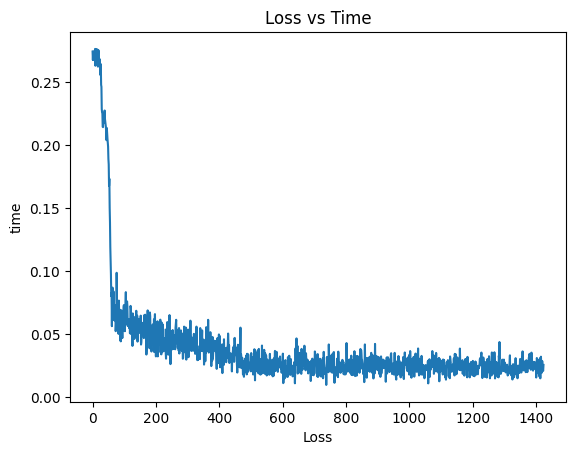

In [149]:
#plot our loss over time for proof of convergence

import matplotlib.pyplot as plt

plt.title("Loss vs Time")
plt.xlabel("Loss")
plt.ylabel("time")
plt.plot(losses)


# Step 6: Evaluating the model on the test set
We use F1 Score as our metric due to high class imbalance and strong impact of false negatives on our task.

Training F1 Score on NN:0.9025824175824175
Testing F1 Score on NN:0.9004395604395604


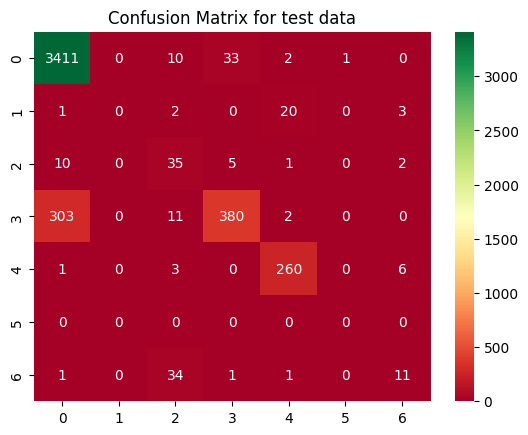

In [150]:

import sklearn.metrics


def evaluate_MyNeuralNetwork(my_nn):
    x_train_tensor = torch.from_numpy(x_train.to_numpy(dtype=np.float32))
    x_test_tensor = torch.from_numpy(x_test.to_numpy(dtype=np.float32))
    train_pred = my_nn.predict(x_train_tensor)
    test_pred = my_nn.predict(x_test_tensor)
    train_score = sklearn.metrics.f1_score(y_train, train_pred, average="micro")
    test_score = sklearn.metrics.f1_score(y_test, test_pred, average="micro")
    print("Training F1 Score on NN:" + str(train_score))
    print("Testing F1 Score on NN:" + str(test_score))
    confusion_matrix = sklearn.metrics.confusion_matrix(y_test, test_pred)
    plt.title("Confusion Matrix for test data")
    sns.heatmap(confusion_matrix, annot=True, cmap='RdYlGn', fmt='d')

evaluate_MyNeuralNetwork(model)

## Step 7 Hyperparameter Investigation

(Note that this is not for checkpoint 4) First we compare these results to a random baseline and a SKLearn NN classifier to verify first they are better than the baseline and second they preform on the same level as a similar architecture. We see that our model preforms better than the random baseline by a significant degree, but does not out preform the sklearn model. This leads me to believe that the major factor is the selection of cost function, as `sklearn.neural_network.MLPClassifier` uses cross entropy loss which was not used earlier and I instead favored MSE.

In [151]:
import sklearn.neural_network
import sklearn.dummy


random_basline = sklearn.dummy.DummyClassifier(strategy="prior")
random_basline.fit(x_train, y_train)
random_basline_f1 = sklearn.metrics.f1_score(random_basline.predict(x_test), y_test, average="micro")
print("Random Baseline F1 Score: " + str(random_basline_f1))

sklearn_nn = sklearn.neural_network.MLPClassifier([9, 7], activation='relu', solver='adam', batch_size=128)
sklearn_nn.fit(x_train, y_train)
sklearn_nn_f1 = sklearn.metrics.f1_score(sklearn_nn.predict(x_test), y_test, average="micro")
print("Sklearn NN F1 Score: " + str(sklearn_nn_f1))

Random Baseline F1 Score: 0.7597802197802199
Sklearn NN F1 Score: 0.9883516483516483


After playing around and tweaking the hyperparameters for a while, this was the model I settled on. I changed the cost function to use NLLLoss instead of MSE to make use of the cross entropy loss despite having a final softmax layer. I played around with inserting `torch.nn.L1Loss` and `torch.nn.L2Loss` in the cost along with a regularization constant, but did not improve performance. 

Epoch: 1/5
Epoch: 2/5
Epoch: 3/5
Epoch: 4/5
Epoch: 5/5
Training F1 Score on NN:0.9528846153846153
Testing F1 Score on NN:0.9538461538461539


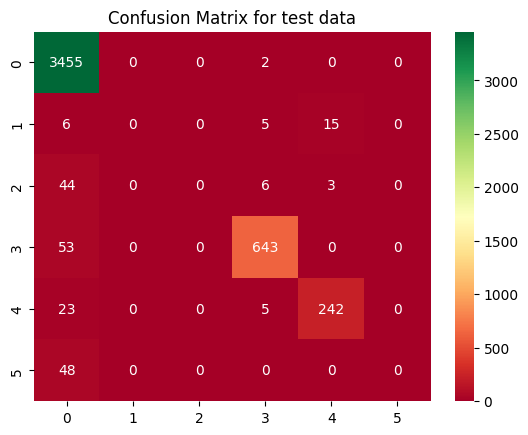

In [164]:
def NLLLoss_cost(outputs, labels):
    return torch.nn.NLLLoss()(outputs, labels) #regularization was here

model2 = MyNeuralNetwork([9, 9, 8, 7])
optimizer = torch.optim.Adam
batch_size = 128
epochs = 5
dataset = create_dataset(x_train, y_train, False)

losses = fit_model(model2, optimizer, dataset, batch_size, epochs, NLLLoss_cost)
evaluate_MyNeuralNetwork(model2)


# Task 3: Hyperparameter Discussion (10 Points)
In task 2 describe how you selected the hyperparameters. What was the 
rationale behind the technique you used? Did you use regularization? Why, or why not? Did you use 
an optimization algorithm? Why or why not?

## Response:
When selecting hyperparameters in task 2, I carefully considered the issue of bias variance tradeoff and tried to find a suite spot by trying out lots of combinations in what I would call an informed human-driven gridsearch. My biggest concern was choice of loss for my cost function and weather or not to select cross entropy loss or MSE. In my finally fully optimized model I ended up selecting Cross entropy via a softmax activation and NLLLoss, since there was much higher performance from the sklearn neural classifier which was using cross entropy. Combining this with expanding the number of hidden layers managed to boost my F1 score by about 5%. I chose my batch size based on speed vs performance, I did not notice a significant difference when using larger batch sizes and smaller batch sizes caused the loss to jump around much more, I settled on 128 because it seemed to be a good compromise, as well as being able to train reasonably fast. For epochs I was able to just look at the convergence graph to see that the model converges quite quickly and was able to cut it at 5 epochs. 

For regularization, I had initially played around with adding L1 and L2 regularization terms to the loss function but did not see a improvements in performance when compared with that of the other hyperparameters. Trying to increase its importance term too much lead to decreases in performance. I am guessing this is because I am already in a spot where there is very little model wide overfitting, the biggest issue is primarily overfitting for the first class since its so large, causing lots of false negatives. 

For optimization I selected Adam with default parameters, while investigating varying parameters for Adam such as learning rate and betas, I found no significant changes in performance. When switching out to SGD I got worse results for F1, presumably this is because Adam is an adaptive learning rate method so the choice of learning rate isn't heavily penalized, as it is in raw SGD. Adam also functions better than most other adaptive learning methods due to implementing the best features from Adadelta (fixing the issue of accumulating squared gradients like in Adagrad) and having a form of momentum. Hence I felt that adam was the best optimization algorithm for my task, which was also observed in practice.    


# Task 4: Baseline Comparison (20 Points)
Create another baseline model (can be any model we covered so far except a 
deep learning model). Using the same training data (as above) train your model and evaluate 
results using the test set. Compare the results of both models (the Neural Network and the 
baseline model). What are the reasons for one model performing better (or not) than the 
other? Explain.

## Implementing and testing the baseline
I choose to implement a decision tree classifier to compare as my baseline. I chose a decision tree to compare against because it is a reasonably different model from a neural net that we have used in class before.

Sklearn NN F1 Score: 0.9892307692307692


<AxesSubplot:title={'center':'Confusion Matrix for test data'}>

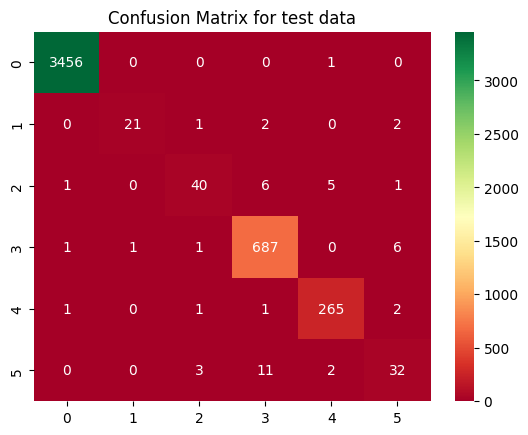

In [167]:
import sklearn.tree

#Using Decision tree as a baseline model 
decision_tree = sklearn.tree.DecisionTreeClassifier()
decision_tree.fit(x_train, y_train)
decision_tree_f1 = sklearn.metrics.f1_score(decision_tree.predict(x_test), y_test, average="micro")
print("Sklearn NN F1 Score: " + str(decision_tree_f1))

#Confusion Matrix plot
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, decision_tree.predict(x_test))
plt.title("Confusion Matrix for test data")
sns.heatmap(confusion_matrix, annot=True, cmap='RdYlGn', fmt='d')

## Analysis 

The decision tree preforms on par with the SKLearn neural network but better than our neural network implementation. I hypothesize that the reason for this dataset works very well for decision trees is because of the medium amounts of interaction within our data as seen by our corelation heatmap in task 2, decision trees preform well in these circumstances. Also there are fewer features which allows the tree to be reasonably small, while in the case of the neural network it is easier to over fit for the dominant classes, which we see occurring in the confusion matrices for both of the custom neural network models. In fact we can see that when increasing the number of layers, despite improving F1 score, these is an even stronger bias for getting false negatives in the dominant class, while the decision tree completely avoids this. In conclusion, I hypothesize that this dataset does not have enough features (9) to take advantages of the power that neural networks offer, with large amounts of perceptions and hidden layers where intermediate features can be extracted such as in the case of computer vision tasks. Hence when taking model complexity into account I would prefer simple models like the decision tree for this dataset. 